# Lesson 2: Multimodal Embeddings

## Multimodal Data

In [1]:
import requests

# You can use your own uploaded images and captions. 
# You will be responsible for the legal use of images that 
#  you are going to use.

url1='http://farm3.staticflickr.com/2519/4126738647_cc436c111b_z.jpg'
cap1='A motorcycle sits parked across from a herd of livestock'

url2='http://farm3.staticflickr.com/2046/2003879022_1b4b466d1d_z.jpg'
cap2='Motorcycle on platform to be worked on in garage'

url3='http://farm1.staticflickr.com/133/356148800_9bf03b6116_z.jpg'
cap3='a cat laying down stretched out near a laptop'

img1 = {
  'flickr_url': url1,
  'caption': cap1,
  'image_path' : './shared_data/motorcycle_1.jpg'
}

img2 = {
    'flickr_url': url2,
    'caption': cap2,
    'image_path' : './shared_data/motorcycle_2.jpg'
}

img3 = {
    'flickr_url' : url3,
    'caption': cap3,
    'image_path' : './shared_data/cat_1.jpg'
}

# download images
imgs = [img1, img2, img3]
for img in imgs:
    data = requests.get(img['flickr_url']).content
    with open(img['image_path'], 'wb') as f:
        f.write(data)

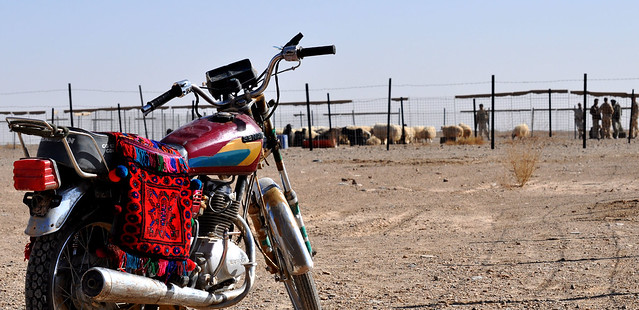

'A motorcycle sits parked across from a herd of livestock'

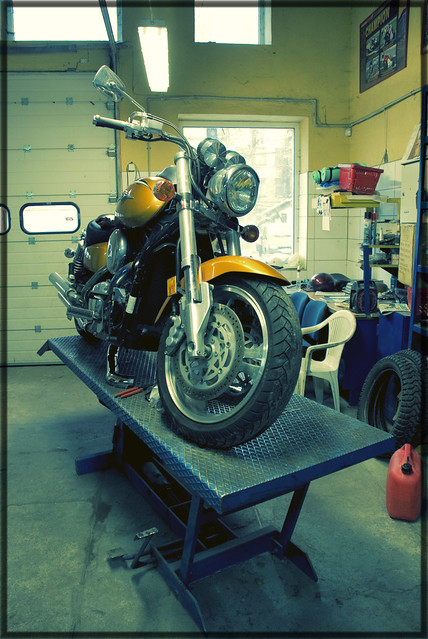

'Motorcycle on platform to be worked on in garage'

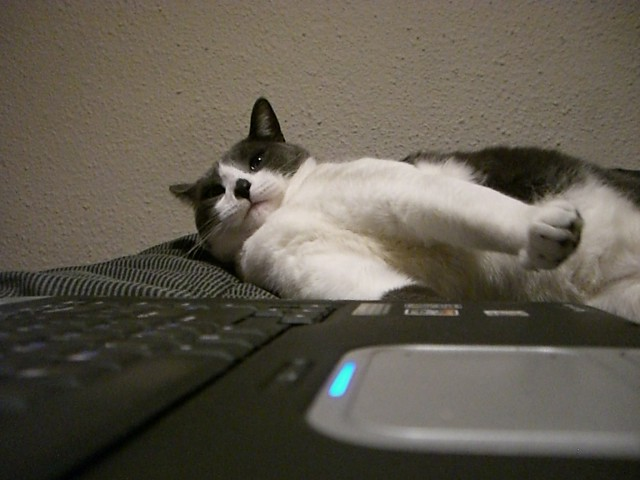

'a cat laying down stretched out near a laptop'

In [2]:
from PIL import Image
from IPython.display import display

for img in [img1, img2, img3]:
    image = Image.open(img['image_path'])
    caption = img['caption']
    display(image)
    display(caption)
    print()

## BridgeTower Embedding Computation

### Setup

In [3]:
import json
import os
import numpy as np
from numpy.linalg import norm
import cv2
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
from utils import encode_image
from utils import bt_embedding_from_prediction_guard as bt_embeddings

### Compute Embedding

In [4]:
embeddings = []
for img in [img1, img2, img3]:
    img_path = img['image_path']
    caption = img['caption']
    base64_img = encode_image(img_path)
    #这个encode_image是什么？
    #encode_image 可能是一个将图像编码为 Base64 格式的函数。Base64 是一种常用的编码方式，可以将二进制数据（例如图片文件）转换为文本格式。
    embedding = bt_embeddings(caption, base64_img)
    embeddings.append(embedding)
    

In [5]:
# Each image-text pair is now converted into multimodal 
# embedding vector which has dimensions of 512.

print(len(embeddings[0]))

512


### Cosine Similarity Between Embedding Vectors

In [6]:
def cosine_similarity(vec1, vec2):
    #余弦相似性的具体公式是什么
    similarity = np.dot(vec1,vec2)/(norm(vec1)*norm(vec2))
    return similarity

余弦相似性的公式如下：

\[
\text{similarity} = \cos(\theta) = \frac{\vec{A} \cdot \vec{B}}{\|\vec{A}\| \|\vec{B}\|}
\]

其中：
- \(\vec{A}\) 和 \(\vec{B}\) 是两个向量。
- \(\vec{A} \cdot \vec{B}\) 表示向量 \(\vec{A}\) 和 \(\vec{B}\) 的点积（即对应元素相乘再求和）。
- \(\|\vec{A}\|\) 和 \(\|\vec{B}\|\) 是向量 \(\vec{A}\) 和 \(\vec{B}\) 的范数（通常是欧几里得范数，表示向量的长度）。
- 余弦相似性度量了两个向量之间的夹角，值在 \([-1, 1]\) 之间：
  - \(1\) 表示两个向量完全相同（夹角为0°）。
  - \(0\) 表示两个向量正交（夹角为90°，即没有相似性）。
  - \(-1\) 表示两个向量方向完全相反（夹角为180°）。

你提到的 `np.dot(vec1, vec2)` 表示两个向量的点积，而 `norm(vec1)` 和 `norm(vec2)` 表示它们的范数，所以你提供的公式正是余弦相似性的计算公式。

In [10]:
ex1_embed = np.array(embeddings[0])
ex2_embed = np.array(embeddings[1])
ex3_embed = np.array(embeddings[2])
sim_ex1_ex2 = cosine_similarity(ex1_embed, ex2_embed)
sim_ex1_ex3 = cosine_similarity(ex1_embed, ex3_embed)

In [8]:
print("Cosine similarity between ex1_embeded and ex2_embeded is:")
display(sim_ex1_ex2)
print("Cosine similarity between ex1_embeded and ex3_embeded is:")
display(sim_ex1_ex3)

Cosine similarity between ex1_embeded and ex2_embeded is:


0.48566270290489155

Cosine similarity between ex1_embeded and ex3_embeded is:


0.17133985252863604

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b>
As expected, since the 1st and the 2nd images all depict motorcycles 
<br>
and the third image depicts a cat, which is different from motorcycle, 
<br>
the Cosine similarity between the 1st and the 2nd examples' embeddings
<br> 
is greater than that between the 1st and the 3rd examples' embeddings.
</p>

### Euclidean Distance Between Embedding Vectors

In [9]:
dist_ex1_ex2 = cv2.norm(ex1_embed, ex2_embed, cv2.NORM_L2)
dist_ex1_ex3 = cv2.norm(ex1_embed, ex3_embed, cv2.NORM_L2)

print("Euclidean distance between ex1_embeded and ex2_embeded is:")
display(dist_ex1_ex2)

print("Euclidean distance between ex1_embeded and ex3_embeded is:")
display(dist_ex1_ex3)

Euclidean distance between ex1_embeded and ex2_embeded is:


1.0142360074073726

Euclidean distance between ex1_embeded and ex3_embeded is:


1.2873695259227447

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b>
As expected, since the 1st and the 2nd images all depict motorcycles 
<br>
and the third image depicts a cat, which is different from motorcycle, 
<br>
the Euclidean distance between the 1st and the 2nd examples' embeddings
<br> 
is smaller than that between the 1st and the 3rd examples' embeddings.
</p>

### Visualizing High-dimensional Data with UMAP

In [11]:
from utils import prepare_dataset_for_umap_visualization as data_prep

# prepare image_text pairs 

# for the first 50 data of Huggingface dataset 
#  "yashikota/cat-image-dataset"
cat_img_txt_pairs = data_prep("yashikota/cat-image-dataset", 
                             "cat", test_size=50)

# for the first 50 data of Huggingface dataset 
#  "tanganke/stanford_cars"
car_img_txt_pairs = data_prep("tanganke/stanford_cars", 
                             "car", test_size=50)


UMAP (Uniform Manifold Approximation and Projection) 是一种用于数据降维的非线性降维技术，尤其擅长可视化高维数据。它是由 McInnes 等人在 2018 年提出的，并且与 t-SNE 一样，常用于高维数据的可视化和探索。UMAP 可以将高维数据映射到低维空间（例如从 100 维降到 2 维或 3 维），保留数据的局部和全局结构。

UMAP 的核心思想是通过构造高维空间中数据点之间的邻接图，假设数据分布在一个流形上，然后找到一个低维空间的表示，该表示能够最好地近似这个邻接图的拓扑结构。

UMAP 的主要特点包括：
1. **保持局部结构**：UMAP 通过邻域图保持局部数据结构，确保相似的数据点在降维后仍然相近。
2. **保持全局结构**：相比于 t-SNE 更关注局部结构，UMAP 在保持数据全局结构上表现更好。
3. **速度快，性能好**：UMAP 的算法实现非常高效，能够处理大规模数据集，且计算速度比 t-SNE 快很多。
4. **参数可调性强**：UMAP 具有多个可调参数，如 `n_neighbors`（邻域大小）、`min_dist`（最小距离），可以调整局部与全局结构之间的平衡。

### UMAP 的工作流程
1. **构建高维空间中的邻域图**：使用 k 近邻算法确定数据点之间的关系，构建一个邻域图。
2. **优化低维嵌入**：将高维空间中的邻域图映射到低维空间，同时尽量保留图的拓扑结构。

### 常用的应用场景
- **数据可视化**：UMAP 常用于可视化高维数据集的低维投影，帮助理解数据的内在结构。
- **特征降维**：可以作为数据预处理步骤，通过降维减少特征数量，提升后续机器学习模型的效率。
- **聚类分析**：UMAP 可以帮助揭示数据中的自然聚类结构，并与其他聚类算法（如 k-means、DBSCAN）结合使用。

### UMAP 与 t-SNE 的比较
- **速度**：UMAP 通常比 t-SNE 更快，尤其在处理大规模数据集时。
- **全局结构**：UMAP 保留的全局结构比 t-SNE 更好。
- **参数可调性**：UMAP 的参数允许对局部和全局结构之间的平衡进行更灵活的调整。

UMAP 是一个强大的工具，在降维、聚类和可视化方面广泛应用，特别是在处理高维数据（如图像、文本或基因组数据）时。



> Note: your images may differ from those seen in the video.

'an image of cat'

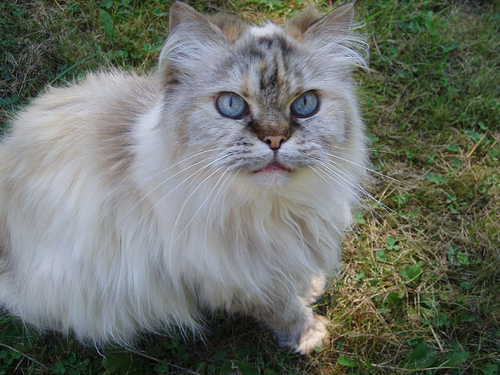

'a beautiful car'

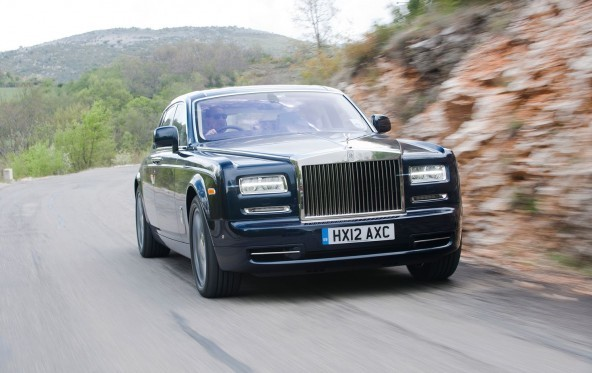

In [12]:
# display an example of a cat image-text pair data
display(cat_img_txt_pairs[0]['caption'])
display(cat_img_txt_pairs[0]['pil_img'])

# display an example of a car image-text pair data
display(car_img_txt_pairs[0]['caption'])
display(car_img_txt_pairs[0]['pil_img'])

In [13]:
# compute BridgeTower embeddings for cat image-text pairs
cat_embeddings = []
for img_txt_pair in tqdm(
                        cat_img_txt_pairs, 
                        total=len(cat_img_txt_pairs)
                    ):
    pil_img = img_txt_pair['pil_img']
    caption = img_txt_pair['caption']
    base64_img = encode_image(pil_img)
    embedding = bt_embeddings(caption, base64_img)
    cat_embeddings.append(embedding)

# compute BridgeTower embeddings for car image-text pairs
car_embeddings = []
for img_txt_pair in tqdm(
                        car_img_txt_pairs, 
                        total=len(car_img_txt_pairs)
                    ):
    pil_img = img_txt_pair['pil_img']
    caption = img_txt_pair['caption']
    base64_img = encode_image(pil_img)
    embedding = bt_embeddings(caption, base64_img)
    car_embeddings.append(embedding)
                        

100%|██████████| 50/50 [00:27<00:00,  1.84it/s]


In [14]:
# function transforms high-dimension vectors to 2D vectors using UMAP
def dimensionality_reduction(embed_arr, label):
    X_scaled = MinMaxScaler().fit_transform(embed_arr)
    print(X_scaled)
    mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
    df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
    df_emb["label"] = label
    print(df_emb)
    return df_emb

In [15]:
# stacking embeddings of cat and car examples into one numpy array
all_embeddings = np.concatenate([cat_embeddings, car_embeddings])

# prepare labels for the 3 examples
labels = ['cat'] * len(cat_embeddings) + ['car'] * len(car_embeddings)

# compute dimensionality reduction for the 3 examples
reduced_dim_emb = dimensionality_reduction(all_embeddings, labels)

[[0.2725776  0.54195026 0.56107173 ... 0.58292106 0.29219235 0.73901728]
 [0.32784086 0.31033107 0.20115725 ... 0.51346983 0.28734325 0.71249237]
 [0.20099745 0.34639742 0.62033632 ... 0.58266881 0.32178097 0.52596222]
 ...
 [0.55984168 0.83872953 0.62807825 ... 0.44383726 0.73166498 0.36429061]
 [0.89959215 0.44024648 0.60217196 ... 0.57787951 0.54380553 0.20384937]
 [0.61195673 0.7070692  0.68028008 ... 0.34510511 0.61244816 0.22321799]]
            X          Y label
0   11.007184  11.891925   cat
1   12.068008  12.679670   cat
2   10.631058  12.070355   cat
3   12.458171  10.501659   cat
4   11.648961  12.300192   cat
..        ...        ...   ...
95  -3.047489  10.149941   car
96  -3.023488  10.913813   car
97  -4.542850  11.114824   car
98  -3.510555  11.523404   car
99  -3.742336  10.739654   car

[100 rows x 3 columns]


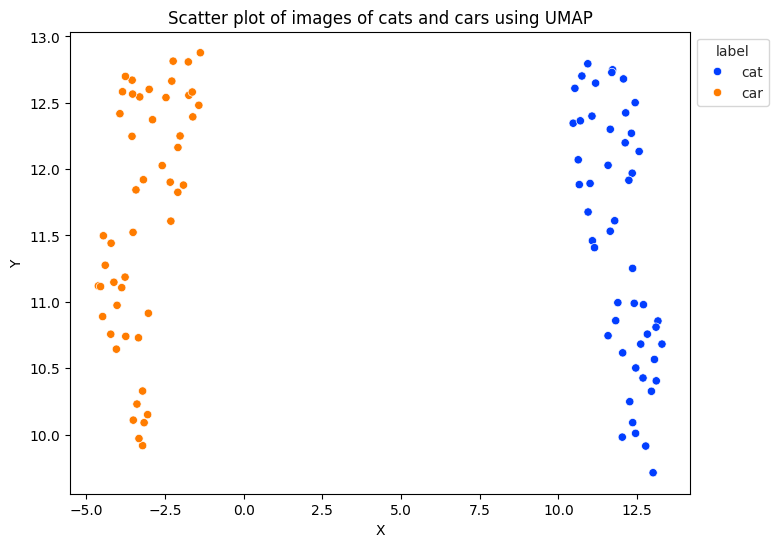

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize

sns.set_style("whitegrid", {'axes.grid' : False})
sns.scatterplot(data=reduced_dim_emb, 
                x=reduced_dim_emb['X'], 
                y=reduced_dim_emb['Y'], 
                hue='label', 
                palette='bright')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of images of cats and cars using UMAP')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b>
<br>
- The embeddings of image-text pairs of `cats` (i.e., blue dots) are
<br>
closed to each other.
<br>
- The embeddings of image-text pairs of `cars` (i.e., orange dots) are
<br>
closed to each other.
<br>
- The embeddings of image-text pairs of `cats` (blue dots) are far away
<br>
from the embeddings of image-text pairs of `cars` (orange dots).
<br>
Note that UMAP includes some randomness, Your clusters may not appear the same as those in the videos however cats and cars should still be clustered separately.
</p>

### Take-Home Notes:

<p style="background-color:#fff1d7; padding:15px; "> <b>Notes:</b>
<br>
- While we presented the two metrics: Cosine Similarity and 
<br>
Euclidean Distance, and one visualization technique for embeddings:
<br>
UMAP above to demonstrate the meaning of embeddings, 
<br>
you can also use other metrics (e.g., Cosine Distance and
<br>
Minkowski Distance) and other visualization techniques (e.g., t-SNE)
<br>
to verify the embeddings.
<br>
- There are other multimodal embedding models that can compute 
<br>
the embeddings for images and texts like BridgeTower does. For example,
<br>
<a href="https://github.com/openai/CLIP">CLIP</a> for image embedding and <a href="https://huggingface.co/sentence-transformers">Sentence Transformer</a> for text embedding.

</p>